In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.spatial import distance_matrix
import random
import xpress  as xp

Using the Community license in this session. If you have a full Xpress license, first set the XPAUTH_PATH environment variable to the full path to your license file, xpauth.xpr, and then restart Python. If you want to use the FICO Community license and no longer want to see this message, set the XPAUTH_PATH environment variable to: /home/andrea/anaconda3/lib/python3.9/site-packages/xpress/license/community-xpauth.xpr
NB: setting XPAUTH_PATH will also affect any other Xpress products installed on your system.


In [3]:
# input
N = 7
L = 1

custom_setup = True
ratio_locker_customers = 0.3
ratio_prime_door_to_door_customer = 0.4

In [4]:
# Customers’ demand and preferences
q = np.ones(N)
C = np.arange(N)

# define all the stores: eg. stores = [W, L0, L1, .... , Lx]
warehouse = ["W"]
lockers = []
for l in range(L):
    lockers.append("L"+str(l))
stores = warehouse+lockers

if custom_setup:
    C_L = [0, 5]
    C_D = [1, 2, 3, 4, 6]
    S_k =[1, 2, 6]
    a_k = ["L0", "W"]
else:
    C_L = []
    C_D = []
    S_k = []
    a_k = []
    for client in C:
        if random.random()  <= ratio_locker_customers :
            # locker customer
            C_L.append(client)
            a_k.append(random.choice(stores)) # TODO assign not a random store but the one that in most case is the nearest to the customer
        else:
            # door to door customer
            C_D.append(client)
            if random.random() >= ratio_prime_door_to_door_customer:
                S_k.append(client)


['Cl0', 'Cl1']
['Cd0', 'Cd1', 'Cd2', 'Cd3', 'Cd4']
['Cd0', 'Cd1', 'Cd2', 'Cd3', 'Cd4', 'Cl0', 'Cl1']


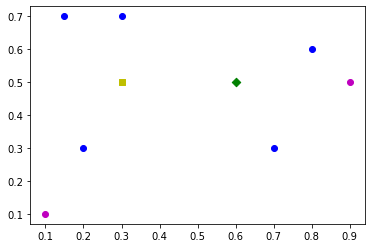

In [5]:
C_location = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
                       [0.9 ,0.5],[0.7 ,0.3]])
CD_location = np.array([[0,0]])
CL_location = np.array([[0,0]])

for i in range(len(C)):
    if i in  C_D:
        CD_location=np.vstack([CD_location, C_location[i]])
    else:
        CL_location = np.vstack([CL_location, C_location[i]])

CD_location = np.delete(CD_location, 0, 0)
CL_location = np.delete(CL_location, 0, 0)

#define all customers
Customers = []
Customers_door = []
Customers_locker = []
for c in range(len(C_D)):
    Customers_door.append("Cd"+str(c))
for c in range(len(C_L)):
    Customers_locker.append("Cl"+str(c))

Customers = Customers_door+Customers_locker

print(Customers_locker)
print(Customers_door)
print(Customers)

plt.scatter(CD_location[:,0],CD_location[:,1],color='b')
plt.scatter(CL_location[:,0],CL_location[:,1],color='m')
W_location = np.array([[0.6 ,0.5]])
plt.scatter(W_location[:,0],W_location[:,1],color='g',marker='D')
L_location = np.array([[0.3 ,0.5]])
plt.scatter(L_location[:,0],L_location[:,1],color ='y',marker='s')

#piccola nota
#come nel paper in verde è la warehouse, in giallo i locker, mentre in blu in customer door to door e in magenta i customer locker

In [6]:
#calcolo la matrice delle distanze:
all_locations = np.array([])
all_locations = np.append(all_locations,W_location)
all_locations = np.vstack([all_locations,L_location])
all_locations = np.vstack([all_locations,CD_location])
all_locations = np.vstack([all_locations,CL_location])

all_buildings = stores + Customers

df = pd.DataFrame(all_locations, columns=['xcord', 'ycord'], index=all_buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()
print(dist_matrix)

            W        L0       Cd0       Cd1       Cd2       Cd3       Cd4  \
W    0.000000  0.300000  0.447214  0.492443  0.360555  0.223607  0.223607   
L0   0.300000  0.000000  0.223607  0.250000  0.200000  0.509902  0.447214   
Cd0  0.447214  0.223607  0.000000  0.403113  0.412311  0.670820  0.500000   
Cd1  0.492443  0.250000  0.403113  0.000000  0.150000  0.657647  0.680074   
Cd2  0.360555  0.200000  0.412311  0.150000  0.000000  0.509902  0.565685   
Cd3  0.223607  0.509902  0.670820  0.657647  0.509902  0.000000  0.316228   
Cd4  0.223607  0.447214  0.500000  0.680074  0.565685  0.316228  0.000000   
Cl0  0.640312  0.447214  0.223607  0.602080  0.632456  0.860233  0.632456   
Cl1  0.300000  0.600000  0.728011  0.776209  0.632456  0.141421  0.282843   

          Cl0       Cl1  
W    0.640312  0.300000  
L0   0.447214  0.600000  
Cd0  0.223607  0.728011  
Cd1  0.602080  0.776209  
Cd2  0.632456  0.632456  
Cd3  0.860233  0.141421  
Cd4  0.632456  0.282843  
Cl0  0.000000  0.8944

In [7]:
#filter data

supply_distances_matrix = dist_matrix.filter(items=stores,axis=1)
supply_distances_matrix  = supply_distances_matrix.filter(items=stores,axis=0)
print(supply_distances_matrix)

PF_distances_matrix = dist_matrix.filter(items=['W']+Customers_door,axis=1)
PF_distances_matrix = PF_distances_matrix.filter(items=['W']+Customers_door,axis=0)
print(PF_distances_matrix)

LF_distances_matrix = dist_matrix.filter(items=lockers+Customers_door,axis=1)
LF_distances_matrix = LF_distances_matrix.filter(items=lockers+Customers_door,axis=0)
print(LF_distances_matrix)

      W   L0
W   0.0  0.3
L0  0.3  0.0
            W       Cd0       Cd1       Cd2       Cd3       Cd4
W    0.000000  0.447214  0.492443  0.360555  0.223607  0.223607
Cd0  0.447214  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.492443  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.360555  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.223607  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.223607  0.500000  0.680074  0.565685  0.316228  0.000000
           L0       Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.000000  0.223607  0.250000  0.200000  0.509902  0.447214
Cd0  0.223607  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.250000  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.200000  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.509902  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.447214  0.500000  0.680074  0.565685  0.316228  0.000000


In [8]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*PF_distances_matrix
LF_delivery_cost = pi_l*LF_distances_matrix
supply_cost = pi_L*supply_distances_matrix
print(supply_cost)
print(PF_delivery_cost)
print(LF_delivery_cost)

        W     L0
W   0.000  0.225
L0  0.225  0.000
            W       Cd0       Cd1       Cd2       Cd3       Cd4
W    0.000000  0.447214  0.492443  0.360555  0.223607  0.223607
Cd0  0.447214  0.000000  0.403113  0.412311  0.670820  0.500000
Cd1  0.492443  0.403113  0.000000  0.150000  0.657647  0.680074
Cd2  0.360555  0.412311  0.150000  0.000000  0.509902  0.565685
Cd3  0.223607  0.670820  0.657647  0.509902  0.000000  0.316228
Cd4  0.223607  0.500000  0.680074  0.565685  0.316228  0.000000
           L0       Cd0       Cd1       Cd2       Cd3       Cd4
L0   0.000000  0.190066  0.212500  0.170000  0.433417  0.380132
Cd0  0.190066  0.000000  0.342646  0.350464  0.570197  0.425000
Cd1  0.212500  0.342646  0.000000  0.127500  0.559000  0.578062
Cd2  0.170000  0.350464  0.127500  0.000000  0.433417  0.480833
Cd3  0.433417  0.570197  0.559000  0.433417  0.000000  0.268794
Cd4  0.380132  0.425000  0.578062  0.480833  0.268794  0.000000


## extra code to delete

In [ ]:
x = np.random.randint(0, 50, 7)
y = np.random.randint(0, 50, 7)
C = [x,y]
plt.scatter(C[0],C[1])
C = np.arange(7)
print(C)
plt.show()

In [ ]:
C = np.random.rand(7,2)
plt.scatter(C[:,0],C[:,1],color='b')
W = np.random.rand(1,2)
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.random.rand(1,2)
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')
print(C)

In [ ]:
C = np.array([[0.1 ,0.1], [0.2 ,0.3],[0.15 ,0.7], [0.3 ,0.7],[0.8 ,0.6],
              [0.9 ,0.5],[0.7 ,0.3]])
plt.scatter(C[:,0],C[:,1],color='b')
W = np.array([[0.6 ,0.5]])
plt.scatter(W[:,0],W[:,1],color='g',marker='D')
L = np.array([[0.3 ,0.5]])
plt.scatter(L[:,0],L[:,1],color ='y',marker='s')

In [ ]:
#calcolo la matrice delle distanze:
data = np.array([])
data = np.append(data,W)
data = np.vstack([data,L])
data = np.vstack([data,C])
buildings =['Warehouse','Locker','c1','c2','c3','c4','c5','c6','c7']
print(len(data))
df = pd.DataFrame(data, columns=['xcord', 'ycord'], index=buildings)
dist_matrix = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
matrix_distance_converted_in_numpy =dist_matrix.to_numpy()

In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy


In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy


In [ ]:
# Delivery Cost
pi = 1
pi_l = 0.85
pi_L = 0.75
ro = 0.5
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
LF_delivery_cost = pi_l*matrix_distance_converted_in_numpy
PF_delivery_cost = pi*matrix_distance_converted_in_numpy
Suplly_cost = pi_L*matrix_distance_converted_in_numpy
